<a href="https://colab.research.google.com/github/jana-jovicic/Neural-Style-Transfer/blob/master/02_Real_Time_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip 'train_dataset.zip'

Archive:  train_dataset.zip
   creating: train_dataset/
  inflating: train_dataset/Places365_val_00005909.jpg  
  inflating: train_dataset/Places365_val_00005901.jpg  
  inflating: train_dataset/Places365_val_00005897.jpg  
  inflating: train_dataset/Places365_val_00005885.jpg  
  inflating: train_dataset/Places365_val_00005884.jpg  
  inflating: train_dataset/Places365_val_00005883.jpg  
  inflating: train_dataset/Places365_val_00005882.jpg  
  inflating: train_dataset/Places365_val_00005881.jpg  
  inflating: train_dataset/Places365_val_00005880.jpg  
  inflating: train_dataset/Places365_val_00005879.jpg  
  inflating: train_dataset/Places365_val_00005876.jpg  
  inflating: train_dataset/Places365_val_00005875.jpg  
  inflating: train_dataset/Places365_val_00005874.jpg  
  inflating: train_dataset/Places365_val_00005873.jpg  
  inflating: train_dataset/Places365_val_00005872.jpg  
  inflating: train_dataset/Places365_val_00005831.jpg  
  inflating: train_dataset/Places365_val_0000583

In [0]:
!unzip 'small_train_dataset.zip'

Archive:  small_train_dataset.zip
   creating: small_train_dataset/
  inflating: small_train_dataset/Places365_val_00008027.jpg  
  inflating: small_train_dataset/Places365_val_00008006.jpg  
  inflating: small_train_dataset/Places365_val_00007910.jpg  
  inflating: small_train_dataset/Places365_val_00007909.jpg  
  inflating: small_train_dataset/Places365_val_00007860.jpg  
  inflating: small_train_dataset/Places365_val_00007806.jpg  
  inflating: small_train_dataset/Places365_val_00007792.jpg  
  inflating: small_train_dataset/Places365_val_00007791.jpg  
  inflating: small_train_dataset/Places365_val_00007626.jpg  
  inflating: small_train_dataset/Places365_val_00007606.jpg  
  inflating: small_train_dataset/Places365_val_00007600.jpg  
  inflating: small_train_dataset/Places365_val_00007594.jpg  
  inflating: small_train_dataset/Places365_val_00007586.jpg  
  inflating: small_train_dataset/Places365_val_00007584.jpg  
  inflating: small_train_dataset/Places365_val_00007559.jpg  
  

In [4]:
!unzip 'images.zip'

Archive:  images.zip
   creating: images/
  inflating: images/content1.jpg     
  inflating: images/content2.jpg     
  inflating: images/content3.jpg     
  inflating: images/content4.jpeg    
  inflating: images/content5.jpg     
  inflating: images/content6.jpg     
  inflating: images/content7.jpg     
  inflating: images/content8.jpg     
  inflating: images/content10.jpg    
  inflating: images/content11.jpg    
  inflating: images/content12.jpg    
  inflating: images/content13.jpg    
  inflating: images/content14.jpg    
  inflating: images/dali-melting-watch.jpg  
  inflating: images/dali-spider-of-the-evening.jpg  
  inflating: images/friedrich-the-wanderer-above-the-sea-of-fog.jpg  
  inflating: images/hokusai-the-great-wave-off-kanagawa.jpg  
  inflating: images/klimt-the-kiss.jpg  
  inflating: images/klimt-The-Tree-Of-Life.jpg  
  inflating: images/manet-water-lilies.jpg  
  inflating: images/munch-the-scream.jpg  
  inflating: images/picasso-muse.jpg  
  inflating: imag

In [3]:
!unzip 'models.zip'

Archive:  models.zip
   creating: models/
  inflating: models/munch-the-scream.h5  


In [13]:
!unzip '02_outputs'

Archive:  02_outputs.zip
   creating: 02_outputs/


In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from tensorflow.keras import models

from IPython import display
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Dropout, Add
from tensorflow.keras.layers import Input, ReLU, ZeroPadding2D, Cropping2D, UpSampling2D

In [0]:
g_image_height = 512
g_image_width  = 512

def loadImages(path):
  imagesList = os.listdir(path)
  loadedImages = []
  for image in imagesList:
    if image.lower().endswith(('.png', '.jpg', '.jpeg')):
      img = Image.open(path + image)
      img = img.resize((g_image_width, g_image_height))
      loadedImages.append(img)
  return loadedImages

In [0]:
class TransformationNetwork(tf.keras.Model):
  def __init__(self):
    super(TransformationNetwork, self).__init__()

    self.block1_conv = Conv2D(filters=32, kernel_size=(9, 9), activation='relu', strides=1, padding='same')
    self.block1_BN = BatchNormalization(axis=3)

    self.block2_conv = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=2, padding='same')
    self.block2_BN = BatchNormalization(axis=3)

    self.block3_conv = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=2, padding='same')
    self.block3_BN = BatchNormalization(axis=3)

    # 5 residual blocks
    self.block4_conv1 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', strides=1)
    self.block4_BN1 = BatchNormalization(axis=3)
    self.block4_conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=1)
    self.block4_BN2 = BatchNormalization(axis=3)
    self.block4_add = Add()

    self.block5_conv1 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', strides=1)
    self.block5_BN1 = BatchNormalization(axis=3)
    self.block5_conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=1)
    self.block5_BN2 = BatchNormalization(axis=3)
    self.block5_add = Add()

    self.block6_conv1 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', strides=1)
    self.block6_BN1 = BatchNormalization(axis=3)
    self.block6_conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=1)
    self.block6_BN2 = BatchNormalization(axis=3)
    self.block6_add = Add()

    self.block7_conv1 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', strides=1)
    self.block7_BN1 = BatchNormalization(axis=3)
    self.block7_conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=1)
    self.block7_BN2 = BatchNormalization(axis=3)
    self.block7_add = Add()

    self.block8_conv1 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', strides=1)
    self.block8_BN1 = BatchNormalization(axis=3)
    self.block8_conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=1)
    self.block8_BN2 = BatchNormalization(axis=3)
    self.block8_add = Add()
    # end of residual blocks

    # self.block9_upsampling = UpSampling2D(2)
    # self.block9_conv = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same')
    # self.block9_BN = BatchNormalization(axis=3)
    # self.block9_relu = ReLU()

    # self.block10_upsampling = UpSampling2D(2)
    # self.block10_conv = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same')
    # self.block10_BN = BatchNormalization(axis=3)
    # self.block10_relu = ReLU()

    # self.block11_conv = Conv2D(filters=3, kernel_size=(9, 9), strides=1, activation='tanh', padding='same')
    # self.block11_BN = BatchNormalization(axis=3)

    self.block9_convTranspose = Conv2DTranspose(filters=64, kernel_size=(3,3), activation='relu', strides=2, padding="same")
    self.block9_BN = BatchNormalization(axis=3)
    
    self.block10_convTranspose = Conv2DTranspose(filters=32, kernel_size=(3,3), activation='relu', strides=2, padding="same")
    self.block10_BN = BatchNormalization(axis=3)
    
    self.block11_convTranspose = Conv2D(filters=3, kernel_size=(9,9), strides=1, padding="same")
    self.block11_BN = BatchNormalization(axis=3)

  def call(self, x, training=True):
    
    x = tf.reshape(x,(-1, g_image_width, g_image_height, 3))
    x = self.block1_conv(x)
    x = self.block1_BN(x,training=training)

    x = self.block2_conv(x)
    x = self.block2_BN(x,training=training)

    x = self.block3_conv(x)
    x = self.block3_BN(x,training=training)

    # residual blocks ...
    x_shortcut = x
    x = self.block4_conv1(x)
    x = self.block4_BN1(x, training=training)
    x = self.block4_conv2(x)
    x = self.block4_BN2(x, training=training)
    x = self.block4_add([x, x_shortcut])

    x_shortcut = x
    x = self.block5_conv1(x)
    x = self.block5_BN1(x, training=training)
    x = self.block5_conv2(x)
    x = self.block5_BN2(x, training=training)
    x = self.block5_add([x, x_shortcut])

    x_shortcut = x
    x = self.block6_conv1(x)
    x = self.block6_BN1(x, training=training)
    x = self.block6_conv2(x)
    x = self.block6_BN2(x, training=training)
    x = self.block6_add([x, x_shortcut])

    x_shortcut = x
    x = self.block7_conv1(x)
    x = self.block7_BN1(x, training=training)
    x = self.block7_conv2(x)
    x = self.block7_BN2(x, training=training)
    x = self.block7_add([x, x_shortcut])

    x_shortcut = x
    x = self.block8_conv1(x)
    x = self.block8_BN1(x, training=training)
    x = self.block8_conv2(x)
    x = self.block8_BN2(x, training=training)
    x = self.block8_add([x, x_shortcut])
    #...

    x = self.block9_convTranspose(x)
    x = self.block9_BN(x,training=training)    

    x = self.block10_convTranspose(x)
    x = self.block10_BN(x,training=training)

    x = self.block11_convTranspose(x)
    x = self.block11_BN(x,training=training)
    x = (tf.nn.tanh(x)+1)*127.5

    return x

In [0]:
content_layers = ['block2_conv2']
#style_layers = ['block1_conv2', 'block2_conv2','block3_conv2', 'block4_conv2','block5_conv2']
style_layers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3']

class VGG16_Model(tf.keras.Model):
  def __init__(self):
    super(VGG16_Model, self).__init__()
    self.vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=(g_image_width, g_image_height, 3), include_top=False)
  
  def call(self, x, training=True):
    self.vgg16.trainable=False
    content_outputs = [self.vgg16.get_layer(layer).output for layer in content_layers]  
    style_outputs = [self.vgg16.get_layer(layer).output for layer in style_layers]    
    outputs = content_outputs + style_outputs
    model = models.Model(self.vgg16.input, outputs)
    x = model(x)
    return x

In [0]:
def calculate_content_loss(F, P):
  '''
    Input: F - feature representation of generated image (transformation network output)
           P - feature representation of original image
  '''
  _, height, width, N = P.shape
  loss = tf.reduce_sum((F - P)**2) / (N * height * width)
  return loss

In [0]:
def gram_matrix(F, N, M):
  '''
    Input: F - tensor; feature represenatation of image in given layer
           N - number of distinctive filters (and feature maps) in given layer
           M - size of each feature map in given layer (hight*width of map)
  '''
  # Reshape the tensor to 2-dim matrix
  F = tf.reshape(F, (M, N))
  return tf.matmul(tf.transpose(F), F)

In [0]:
def calculate_style_loss_in_one_layer(g, a):
  ''' 
  Input:  a - feature representation of the style image at given layer
          g - feature representation of the generated image at given layer
  '''
  _, height, width, N = g.shape
  M = height * width
  G = gram_matrix(g, N, M)
  A = gram_matrix(a, N, M)
  #E = tf.reduce_sum((G - A) ** 2) / (4 * (N**2) * (M**2))
  E = tf.reduce_sum((G - A) ** 2) / ((N**2) * (M**2))
  #E = tf.reduce_sum((G - A) ** 2)
  return E

In [0]:
def calculate_style_loss(y_hat_features_lst, style_features_lst):
  '''
  Input:
    y_hat_features_lst - transform_net image features for many layers
    style_features_lst - style image features for many layers     
  '''
  style_score = 0
  style_weight_per_layer = 1.0 / float(len(style_features_lst))  #uniformly
  for i in range(len(style_features_lst)):
    style_loss_single = calculate_style_loss_in_one_layer(y_hat_features_lst[i], style_features_lst[i])
    style_score += style_weight_per_layer * style_loss_single
  return style_score

In [0]:
def calculate_variation_loss(y_hat):
  """
  Input:
    y_hat - transform_net output 
  """

  # https://www.oreilly.com/library/view/hands-on-transfer-learning/9781788831307/73d3fd7c-9996-4758-865c-32f0138dd46b.xhtml
  # https://stats.stackexchange.com/questions/381273/total-variation-regularization-in-deep-learning
  a = tf.square(y_hat[:, :g_image_height-1, :g_image_width-1, :] - y_hat[:, 1:, :g_image_width-1, :])   
  b = tf.square(y_hat[:, :g_image_height-1, :g_image_width-1, :] - y_hat[:, :g_image_height-1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, 1.25))

In [0]:
def calculate_loss(model,y_hat,content_image,style_image,
                   content_weight,style_weight,variation_weight, means):
  
  y_hat -= means
  content_features=model(content_image) 
  style_features_lst=model(style_image)
  y_hat_features=model(y_hat)                
  
  loss_content = calculate_content_loss(y_hat_features[0], content_features[0])
  loss_style = calculate_style_loss(y_hat_features[1:], style_features_lst[1:])
  loss_variation = calculate_variation_loss(y_hat)
  #loss_variation = tf.image.total_variation(y_hat)

  total_loss = content_weight * loss_content + style_weight * loss_style + variation_weight * loss_variation
  return total_loss, loss_content, loss_style, loss_variation

In [0]:
def train_step(model,x_image,content_image,style_image, content_weight,style_weight,variation_weight, means):
  
  with tf.GradientTape() as tape:
    
    y_hat = transform_net(x_image, training=True)
    total_loss, loss_c, loss_s, loss_var = calculate_loss(model,y_hat,content_image,style_image,
                            content_weight,style_weight,variation_weight, means)

  grads = tape.gradient(total_loss, transform_net.trainable_variables)
  opt.apply_gradients(zip(grads, transform_net.trainable_variables))
  return total_loss, loss_c, loss_s, loss_var

In [0]:
def show_stylized_training_images(images):
  display.clear_output(wait=True)
  y_hats = transform_net(images, training=False)
  #print(y_hats[0])
  imgs=[]
  for i in range(y_hats.shape[0]):
    y_hat = np.array(y_hats[i,:,:,:],dtype='uint8')
    imgs.append(y_hat)

  # show 4 random images
  m = len(imgs) 
  plt.figure(figsize=(10,10))
  for j,i in enumerate(np.random.choice(m,4)):
      plt.subplot(2,2,j+1)
      plt.imshow(imgs[i])
      plt.axis('off')
      plt.grid(False)
  plt.show()

In [0]:
vgg16 = VGG16_Model()
transform_net= TransformationNetwork()
opt = tf.optimizers.Adam(learning_rate=1e-3)

def train(style_image_path, train_data_path):

  epochs = 500
  content_weight=90
  style_weight=0.3
  variation_weight=1e-4
  
  style_image = Image.open(style_image_path)
  style_image = style_image.resize((g_image_width, g_image_height))
  plt.figure(figsize=(7,7))
  plt.title('Style image for training')
  plt.imshow(style_image) 
  plt.show()

  print('Loading content images...')
  content_images = loadImages(train_data_path)
  print('Content images loaded.')

  n = len(content_images)
  content_array = np.zeros(shape=(n, g_image_width, g_image_height, 3), dtype='float32')
  for i in range(n):
    #print(content_images[i])
    content_array[i,:,:,:] = np.asarray(content_images[i], dtype='float32')
    
  style_array = np.asarray(style_image, dtype='float32')
  # print('Content array shape: {}'.format(content_array.shape))
  # print('Style array shape: {}'.format(style_array.shape))

  # Get the input for transform_net
  transform_net_input = content_array/255

  # Get the input for vgg16
  means = np.mean(content_array, tuple(range(3))); 
  #print('Means for vgg16 model: {}'.format(means))
  content_array -= means
  style_array -= means

  style_array = np.expand_dims(style_array, axis=0)
  #print('Content array shape: {}'.format(content_array.shape))
  #print('Style array shape: {}'.format(style_array.shape))

  for epoch in range(epochs):
    start = time.time()
    
    for i in range(transform_net_input.shape[0]):
      l_t, loss_c, loss_s, loss_var = train_step(vgg16, np.expand_dims(transform_net_input[i],axis=0), np.expand_dims(content_array[i],axis=0),style_array, content_weight,style_weight,variation_weight, means)
      #print('Train step completed.')

    end = time.time()
    show_stylized_training_images(transform_net_input)
    print('Epoch {}:'.format(epoch))
    print ('\t Seconds {}'.format(end - start))
    print ('\t Total Loss {}'.format(l_t))
    print ('\t Content Loss {}'.format(loss_c))
    print ('\t Style Loss {}'.format(loss_s))
    print ('\t Variation Loss {}'.format(loss_var))
    #print ('\t Grads {}'.format(grads))
    #transform_net.save_weights('model_epoch'+ str(epoch) +'.h5')

  transform_net.save_weights(style_image_path[:-4] +'.h5')

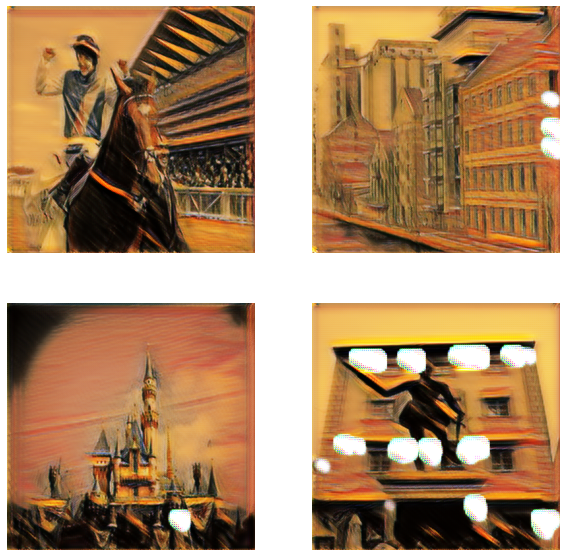

Epoch 499:
	 Seconds 12.533367156982422
	 Total Loss 15059249.0
	 Content Loss 105325.765625
	 Style Loss 18154120.0
	 Variation Loss 1336936960.0


In [0]:
train('images/munch-the-scream.jpg', './small_train_dataset/')

In [0]:
def stylize_test_image(test_img, model_path):

  #test_image = Image.open(test_image_path)

  # preprocess image
  #test_image = test_img.resize((g_image_width, g_image_height))
  test_image = np.array(test_img,dtype='float32')
  test_image = kp_image.img_to_array(test_image)
  test_image = np.expand_dims(test_image,axis=0)
  test_image /= 255 

  # transfer style
  trained_net = TransformationNetwork()
  trained_net(tf.Variable(np.zeros((1, g_image_width, g_image_height, 3),dtype=np.float32)), training=True)
  trained_net.load_weights(model_path, by_name=False)

  test_img = trained_net(test_image,training=False)
  test_img = test_img.numpy()
  test_img = test_img[0,:,:,:]
  test_img = np.clip(test_img,0,255).astype('uint8')

  return test_img

In [0]:
def show_stylized_test_image(model_path, test_image_path, new_image_path):

  test_img = Image.open(test_image_path)
  old_dimensions = test_img.size
  
  test_image = copy.deepcopy(test_img)
  test_image = test_image.resize((g_image_width, g_image_height))

  test_image = stylize_test_image(test_image, model_path)

  test_image = Image.fromarray(test_image).resize(old_dimensions, Image.ANTIALIAS)

  plt.figure(figsize=(10,10))
  #plt.imshow(np.clip(test_image,0,255).astype('uint8'))
  plt.imshow(test_image)
  plt.grid(False)
  plt.axis('off')
  plt.savefig(new_image_path, bbox_inches='tight')

In [0]:
import cv2

def stylize_video(video_path, new_wideo_path, model_path):

  cap = cv2.VideoCapture(video_path)
  
  if (cap.isOpened() == False): 
    print("Unable to open video capture")
    
  fps = 24
  out = cv2.VideoWriter(new_wideo_path, cv2.VideoWriter_fourcc('M','J','P','G'), fps, (g_image_width,g_image_height))
  
  while(True):
    ret, frame = cap.read()
    
    if ret: 
      img = cv2.resize(frame, (g_image_width,g_image_height)) 
      stylized_image = stylize_test_image(img, model_path)
      out.write(stylized_image[:,:,::-1])
    else:
      break 
  
  cap.release()
  out.release()
  cv2.destroyAllWindows() 

In [0]:
stylize_video('video2.mp4', '02_outputs/video2-munch-the-scream.mp4', 'munch-the-scream.h5')

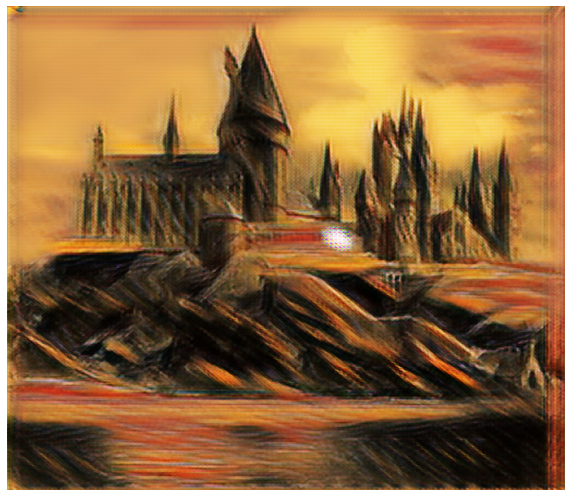

In [32]:
show_stylized_test_image('models/munch-the-scream.h5', 'images/content6.jpg', '02_outputs/content6-munch-the-scream.jpg')

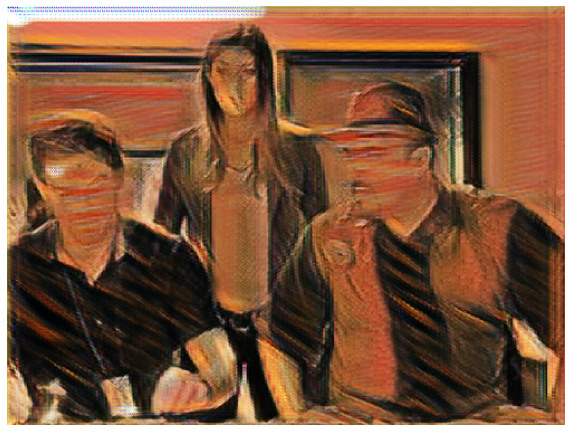

In [33]:
show_stylized_test_image('models/munch-the-scream.h5', 'images/content14.jpg', '02_outputs/content14-munch-the-scream.jpg')

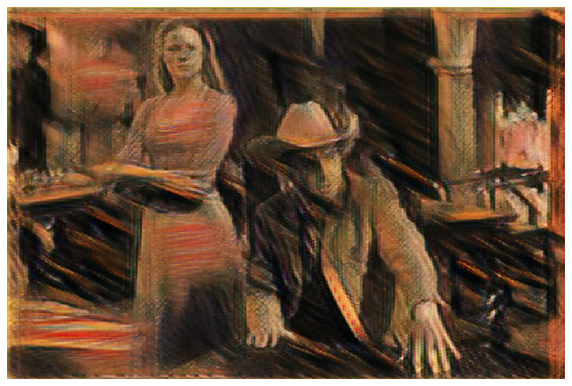

In [28]:
show_stylized_test_image('models/munch-the-scream.h5', 'images/content15.jpg', '02_outputs/content15-munch-the-scream.jpg')

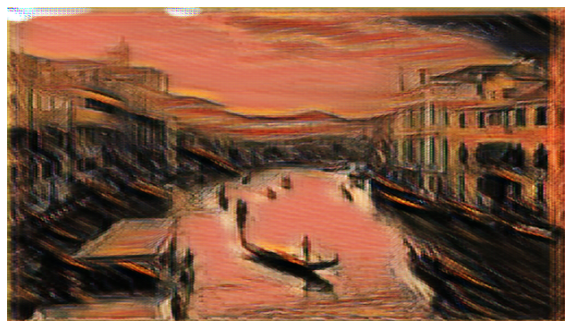

In [35]:
show_stylized_test_image('models/munch-the-scream.h5', 'images/content3.jpg', '02_outputs/content3-munch-the-scream.jpg')